# A Neural Network for Regression (Estimate blood pressure from PPG signal)

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [HW page](http://kovan.ceng.metu.edu.tr/~sinan/DL/index.html) on the course website.*

Having gained some experience with neural networks, let us train a network that estimates the blood pressure from a PPG signal window.

All of your work for this exercise will be done in this notebook.

# A Photoplethysmograph (PPG) signal

A PPG (photoplethysmograph) signal is a signal obtained with a pulse oximeter, which illuminates the skin and measures changes in light absorption. A PPG signal carries rich information about the status of the cardiovascular health of a person, such as breadth rate, heart rate and blood pressure. An example is shown below, where you also see the blood pressure signal that we will estimate (the data also has the ECG signal, which you should ignore).

<img width="80%" src="PPG_ABG_ECG_example.png">


# Constructing the Dataset 

In this task, you are expected to perform the full pipeline for creating a learning system from scratch. Here is how you should construct the dataset:
* Download the dataset from the following website, and only take "Part 1" from it (it is too big): https://archive.ics.uci.edu/ml/datasets/Cuff-Less+Blood+Pressure+Estimation
* Take a window of size $W$ from the PPG channel between time $t$ and $t+W$. Let us call this $\textbf{x}_t$.
* Take the corresponding window of size $W$ from the ABP (arterial blood pressure) channel between time $t$ and $t+W$. Find the maxima and minima of this signal within the window (you can use "findpeaks" from Matlab or "find_peaks_cwt" from scipy). Here is an example window from the ABP signal, and its peaks:
 <img width="60%" src="ABP_peaks.png">
    
* Calculate the average of the maxima, call it $y^1_t$, and the average of the minima, call it $y^2_t$.
* Slide the window over the PPG signals and collect many $(\textbf{x}_t, <y^1_t, y^2_t>)$ instances. In other words, your network outputs two values.
* This will be your input-output for training the network.

In [5]:
import random
import numpy as np
from metu.data_utils import load_dataset
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading extenrnal modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
    """ returns relative error """
    return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

In [6]:
# Create a small net and some toy data to check your implementations.
# Note that we set the random seed for repeatable experiments.
from cs231n.classifiers.neural_net_for_regression import TwoLayerNet

input_size = 4
hidden_size = 10
num_classes = 3
num_inputs = 5

def init_toy_model():
    np.random.seed(0)
    return TwoLayerNet(input_size, hidden_size, num_classes, std=1e-1)

def init_toy_data():
    np.random.seed(1)
    X = 10 * np.random.randn(num_inputs, input_size)
    y = np.array([[0, 1, 2], [1, 2, 3], [2, 3, 4], [2, 1, 4], [2, 1, 4]])
    return X, y

net = init_toy_model()
X, y = init_toy_data()

# Forward pass: compute scores
Open the file `cs231n/classifiers/neural_net_for_regression.py` and look at the method `TwoLayerNet.loss`. This function is very similar to the loss functions you have written for the previous exercises: It takes the data and weights and computes the *regression* scores, the squared error loss, and the gradients on the parameters. 

To be more specific, you will implement the following loss function:

$$\frac{1}{2}\sum_i\sum_{j} (o_{ij} - y_{ij})^2 + \frac{1}{2}\lambda\sum_j w_j^2,$$

where $i$ runs through the samples in the batch; $o_{ij}$ is the prediction of the network for the $i^{th}$ sample for output $j$, and $y_{ij}$ is the correct value; $\lambda$ is the weight of the regularization term.

The first layer uses ReLU as the activation function. The output layer does not use any activation functions.

Implement the first part of the forward pass which uses the weights and biases to compute the scores for all inputs.

In [9]:
scores = net.loss(X)
print ('Your scores:')
print (scores)
print('')
print ('correct scores:')
correct_scores = np.asarray([
  [-0.81233741, -1.27654624, -0.70335995],
  [-0.17129677, -1.18803311, -0.47310444],
  [-0.51590475, -1.01354314, -0.8504215 ],
  [-0.15419291, -0.48629638, -0.52901952],
  [-0.00618733, -0.12435261, -0.15226949]])
print (correct_scores)
print('')

# The difference should be very small. We get < 1e-7
print ('Difference between your scores and correct scores:')
print (np.sum(np.abs(scores - correct_scores)))

Your scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

correct scores:
[[-0.81233741 -1.27654624 -0.70335995]
 [-0.17129677 -1.18803311 -0.47310444]
 [-0.51590475 -1.01354314 -0.8504215 ]
 [-0.15419291 -0.48629638 -0.52901952]
 [-0.00618733 -0.12435261 -0.15226949]]

Difference between your scores and correct scores:
3.68027209324e-08


# Forward pass: compute loss
In the same function, implement the second part that computes the data and regularizaion loss.

In [13]:
loss, _ = net.loss(X, y, reg=0.1)
correct_loss = 66.3406756909
print('loss:', loss)
# should be very small, we get < 1e-10
print ('Difference between your loss and correct loss:')
print (np.sum(np.abs(loss - correct_loss)))

loss: 66.3406756909
Difference between your loss and correct loss:
2.54800625044e-11


# Backward pass
Implement the rest of the function. This will compute the gradient of the loss with respect to the variables `W1`, `b1`, `W2`, and `b2`. Now that you (hopefully!) have a correctly implemented forward pass, you can debug your backward pass using a numeric gradient check:

In [14]:
from cs231n.gradient_check import eval_numerical_gradient

# Use numeric gradient checking to check your implementation of the backward pass.
# If your implementation is correct, the difference between the numeric and
# analytic gradients should be less than 1e-8 for each of W1, W2, b1, and b2.

loss, grads = net.loss(X, y, reg=0.1)

# these should all be less than 1e-8 or so
for param_name in grads:
    f = lambda W: net.loss(X, y, reg=0.1)[0]
    param_grad_num = eval_numerical_gradient(f, net.params[param_name])
    print ('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W2 max relative error: 3.755046e-04
b2 max relative error: 1.443387e-06
W1 max relative error: 5.463838e-04
b1 max relative error: 2.188996e-07


# Load the PPG dataset for training your regression network

In [42]:
# Load the PPG dataset
# If your memory turns out to be sufficient, try loading a subset
def get_data(datafile,
             training_ratio=0.9,
             test_ratio=0.06,
             val_ratio=0.01,
             window=input_size,
             width_limit=50,
             stride=750):
    # Load the PPG training data stride
    X, y = load_dataset(datafile, window=window, stride=stride, width_limit=width_limit)

    # TODO: Split the data into training, validation and test sets
    length=len(y)
    num_training=int(length*training_ratio)
    num_val = int(length*val_ratio)
    num_test = min((length-num_training-num_val), int(length*test_ratio))
    mask = range(num_training-1)
    X_train = X[mask]
    y_train = y[mask]
    mask = range(num_training, num_training+num_test)
    X_test = X[mask]
    y_test = y[mask]
    mask = range(num_training+num_test, num_training+num_test+num_val)
    X_val = X[mask]
    y_val = y[mask]

    return X_train, y_train, X_val, y_val, X_test, y_test

datafile = './metu/dataset/Part_1.mat' #TODO: PATH to your data file
input_size = 1000 # TODO: Size of the input of the network

X_train, y_train, X_val, y_val, X_test, y_test = get_data(datafile, window=input_size, width_limit=50, stride=750)
print ("Number of instances in the training set: ", len(X_train))
print ("Number of instances in the validation set: ", len(X_val))
print ("Number of instances in the testing set: ", len(X_test))

Number of instances in the training set:  23669
Number of instances in the validation set:  263
Number of instances in the testing set:  1578


# Now train our network on the PPG dataset

In [53]:
# Now, let's train a neural network

input_size = input_size
hidden_size = 500 # TODO: Choose a suitable hidden layer size
num_classes = 2 # We have two outputs
net = TwoLayerNet(input_size, hidden_size, num_classes)

# Train the network
stats = net.train(X_train, y_train, X_val, y_val,
            num_iters=50000, batch_size=64,
            learning_rate=1e-5, learning_rate_decay=0.95,
            reg=0.5, verbose=True)

# Predict on the validation set
#val_err = ... # TODO: Perform prediction on the validation set
val_err = np.sum(np.square(net.predict(X_val) - y_val), axis=1).mean()
print ('Validation error: ', val_err)

iteration 0 / 50000: loss 534330.183591
iteration 100 / 50000: loss 501336.635259
iteration 200 / 50000: loss 451644.055357
iteration 300 / 50000: loss 378601.070585
iteration 400 / 50000: loss 375677.026417
iteration 500 / 50000: loss 331224.788309
iteration 600 / 50000: loss 313916.900274
iteration 700 / 50000: loss 254183.236685
iteration 800 / 50000: loss 211796.817715
iteration 900 / 50000: loss 253944.680456
iteration 1000 / 50000: loss 206615.596300
iteration 1100 / 50000: loss 184450.992006
iteration 1200 / 50000: loss 200981.136536
iteration 1300 / 50000: loss 153581.951940
iteration 1400 / 50000: loss 33338.694818
iteration 1500 / 50000: loss 121730.195078
iteration 1600 / 50000: loss 93690.350939
iteration 1700 / 50000: loss 120235.627992
iteration 1800 / 50000: loss 55887.420876
iteration 1900 / 50000: loss 37860.012189
iteration 2000 / 50000: loss 97783.312405
iteration 2100 / 50000: loss 95808.354790
iteration 2200 / 50000: loss 91224.020585
iteration 2300 / 50000: loss 6

iteration 19300 / 50000: loss 25502.834828
iteration 19400 / 50000: loss 35374.508432
iteration 19500 / 50000: loss 24453.203555
iteration 19600 / 50000: loss 27480.425100
iteration 19700 / 50000: loss 25739.401765
iteration 19800 / 50000: loss 34817.330214
iteration 19900 / 50000: loss 30790.293896
iteration 20000 / 50000: loss 50936.255772
iteration 20100 / 50000: loss 27774.657881
iteration 20200 / 50000: loss 36325.119878
iteration 20300 / 50000: loss 26682.417342
iteration 20400 / 50000: loss 26517.366452
iteration 20500 / 50000: loss 28404.404600
iteration 20600 / 50000: loss 23678.780047
iteration 20700 / 50000: loss 27219.183373
iteration 20800 / 50000: loss 28626.753386
iteration 20900 / 50000: loss 35552.682291
iteration 21000 / 50000: loss 31247.715540
iteration 21100 / 50000: loss 28438.229833
iteration 21200 / 50000: loss 24482.248822
iteration 21300 / 50000: loss 25903.533791
iteration 21400 / 50000: loss 27380.746300
iteration 21500 / 50000: loss 27371.614226
iteration 2

iteration 38400 / 50000: loss 29587.361658
iteration 38500 / 50000: loss 32529.065356
iteration 38600 / 50000: loss 36043.483563
iteration 38700 / 50000: loss 31360.514912
iteration 38800 / 50000: loss 34531.489324
iteration 38900 / 50000: loss 34315.281410
iteration 39000 / 50000: loss 29752.326085
iteration 39100 / 50000: loss 22456.579883
iteration 39200 / 50000: loss 29149.510369
iteration 39300 / 50000: loss 22727.754888
iteration 39400 / 50000: loss 27094.105787
iteration 39500 / 50000: loss 22245.346553
iteration 39600 / 50000: loss 28931.644017
iteration 39700 / 50000: loss 30673.185221
iteration 39800 / 50000: loss 38195.713337
iteration 39900 / 50000: loss 27154.815175
iteration 40000 / 50000: loss 25142.198913
iteration 40100 / 50000: loss 37685.036742
iteration 40200 / 50000: loss 36676.728734
iteration 40300 / 50000: loss 29254.774175
iteration 40400 / 50000: loss 32005.677007
iteration 40500 / 50000: loss 27360.635622
iteration 40600 / 50000: loss 27899.159934
iteration 4

# Debug the training and improve learning
You should be able to get a validation error of 5.

So far so good. But, is it really good? Let us plot the validation and training errors to see how good the network did. Did it memorize or generalize? Discuss your observations and conclusions. If its performance is not looking good, propose and test measures. This is the part that will show me how well you have digested everything covered in the lectures.

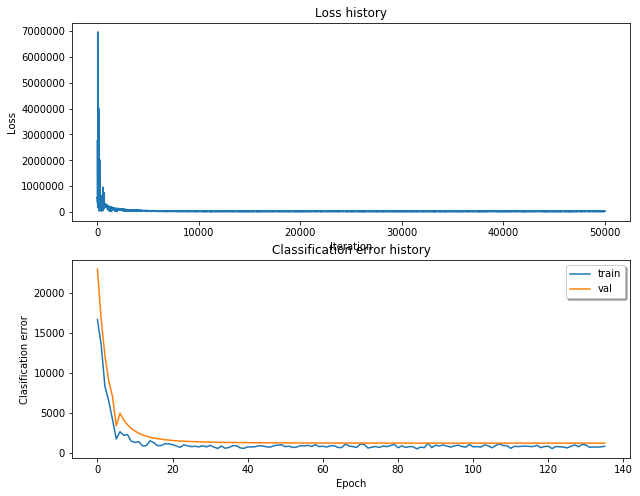

In [55]:
# Plot the loss function and train / validation errors
plt.subplot(2, 1, 1)
plt.plot(stats['loss_history'])
plt.title('Loss history')
plt.xlabel('Iteration')
plt.ylabel('Loss')

plt.subplot(2, 1, 2)
train = plt.plot(stats['train_err_history'], label='train')
val = plt.plot(stats['val_err_history'], label='val')
plt.legend(loc='upper right', shadow=True)
plt.title('Classification error history')
plt.xlabel('Epoch')
plt.ylabel('Clasification error')
plt.show()

In [52]:
print(stats['train_err_history'])
iterations_per_epoch = int(max(X_train.shape[0] / 32, 1))
print(iterations_per_epoch, X_train.shape[0])

[19150.281411869848]
739 23669


# Finetuning and Improving Your Network (Bonus)
There are many aspects and hyper-parameters you can play with. Do play with them and find the best setting here.